# Resolution Sensitivity

We performed three JAX-ALFA simulations with grids: (i) 64x64x64, (ii) 128x128x128, and (iii) 256x256x256. All the computations use double 
precision on an NVIDIA A6000-Ada GPU. 

**Load the necessary packages**

In [1]:
import os
import re
import glob
import numpy as np
import matplotlib.pyplot as plt

**Input & Output Directories**

In [2]:
# User: please change these paths according to your directory structure
BaseDir   = ('/Users/sukantabasu/Dropbox/Codes/LES/JAX-ALFA/JAXALFA0.1/')

CaseDir1   = os.path.join(BaseDir, 'examples/CBL_N91/runs/64x64x64/')
OutputDir1 = os.path.join(CaseDir1, 'output_damp300/') 

CaseDir2   = os.path.join(BaseDir, 'examples/CBL_N91/runs/128x128x128/')
OutputDir2 = os.path.join(CaseDir2, 'output_damp300/') 

CaseDir3   = os.path.join(BaseDir, 'examples/CBL_N91/runs/256x256x256/')
OutputDir3 = os.path.join(CaseDir3, 'output_damp300/') 

**Input Information from the Config File**

In [3]:
# Common settings across the simulations
l_z = 5000 # domain height (m)
z_damping = 3300 # damping layer height (m)
RelaxTime = 300  # relaxation time (s)
SimTime = 3.5*3600  # total simulation time (sec)
OutputInterval = 60 # frequency of output (sec)

# Averaging window
T_start = 3*3600 # unit: sec
T_end = 3.5*3600 # unit: sec

In [4]:
# Simulation 1
nz_1 = 64 # number of grid points in z direction

# Simulation 2
nz_2 = 128 # number of grid points in z direction

# Simulation 3
nz_3 = 256 # number of grid points in z direction

**Derived Variables**

In [5]:
# Half levels for u, v, TH variables
z_u_1 = np.array([(k + 0.5) * l_z / (nz_1 - 1) for k in range(nz_1)])
z_u_2 = np.array([(k + 0.5) * l_z / (nz_2 - 1) for k in range(nz_2)])
z_u_3 = np.array([(k + 0.5) * l_z / (nz_3 - 1) for k in range(nz_3)])

# Full levels for fluxes
z_w_1 = np.array([(k) * l_z / (nz_1 - 1) for k in range(nz_1)])
z_w_2 = np.array([(k) * l_z / (nz_2 - 1) for k in range(nz_2)])
z_w_3 = np.array([(k) * l_z / (nz_3 - 1) for k in range(nz_3)])

# Averaging indices
T_start_index = int(T_start / OutputInterval) - 1
T_end_index = int(T_end / OutputInterval) - 1

**Function to Load Statistics & Perform Temporal Averaging**

In [6]:
def LoadStatsAverage(OutputDir, T_start_index, T_end_index):
    
    # Get All Statistics Files in Chronological Order
    OutputFiles = os.path.join(OutputDir, 'ALFA_Statistics_Iteration_*.npz')
    StatFiles   = sorted(
        glob.glob(OutputFiles),
        key=lambda x: int(re.search(r'Iteration_(\d+)', x).group(1))
    )
    
    # Initialize lists
    TH  = []
    u2  = []
    v2  = []
    w2  = []
    TH2 = []
    wTH = []
    qz = []
    
    # Process each file
    for file in StatFiles:
        with np.load(file) as data:
            TH.append(data['TH'])
            u2.append(data['u2'])
            v2.append(data['v2'])
            w2.append(data['w2'])
            TH2.append(data['TH2'])
            wTH.append(data['wTH'])
            qz.append(data['qz'])
    
    # Convert lists to numpy arrays
    TH = np.array(TH)
    u2 = np.array(u2)
    v2 = np.array(v2)
    w2 = np.array(w2)
    TH2 = np.array(TH2)
    wTH = np.array(wTH)
    qz = np.array(qz)
    
    # Temporal averaging
    TH_avg  = np.mean(TH[T_start_index:T_end_index+1,:],axis=0)

    u2_avg  = np.mean(u2[T_start_index:T_end_index+1,:],axis=0)
    v2_avg  = np.mean(v2[T_start_index:T_end_index+1,:],axis=0)
    w2_avg  = np.mean(w2[T_start_index:T_end_index+1,:],axis=0)
    TH2_avg = np.mean(TH2[T_start_index:T_end_index+1,:],axis=0)
    
    wTH_avg = np.mean(wTH[T_start_index:T_end_index+1,:],axis=0)
    qz_avg  = np.mean(qz[T_start_index:T_end_index+1,:],axis=0)    
    
    return (TH_avg, 
            u2_avg, v2_avg, w2_avg, TH2_avg, 
            wTH_avg, qz_avg)

**Extract Temporally Averaged Statistics**

In [7]:
(TH_avg_1, 
 u2_avg_1, v2_avg_1, w2_avg_1, TH2_avg_1, 
 wTH_avg_1, qz_avg_1)\
    = LoadStatsAverage(OutputDir1, T_start_index, T_end_index)

(TH_avg_2, 
 u2_avg_2, v2_avg_2, w2_avg_2, TH2_avg_2, 
 wTH_avg_2, qz_avg_2)\
    = LoadStatsAverage(OutputDir2, T_start_index, T_end_index)

(TH_avg_3, 
 u2_avg_3, v2_avg_3, w2_avg_3, TH2_avg_3, 
 wTH_avg_3, qz_avg_3)\
    = LoadStatsAverage(OutputDir3, T_start_index, T_end_index)

**Plotting Configurations**

In [8]:
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 16,
    "axes.labelsize": 18,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14
})

**Profiles of Velocity Variances**

The start of the damping layer is shown by dotted lines. 

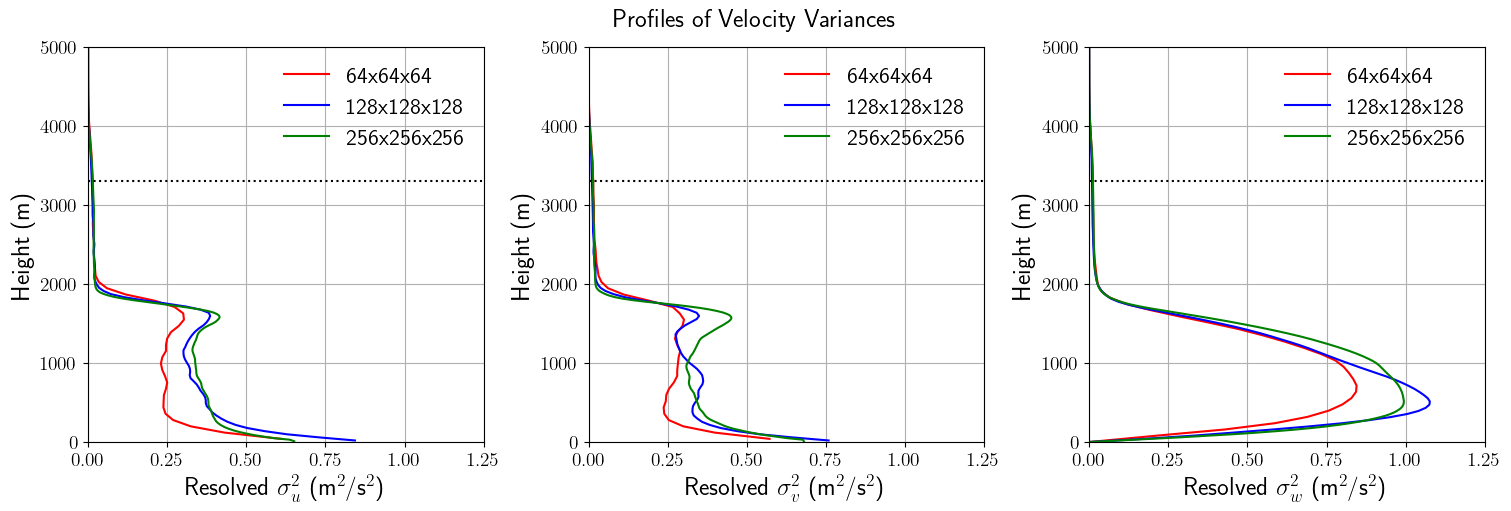

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

axs[0].plot(u2_avg_1, z_u_1, 'r-', label='64x64x64')
axs[0].plot(u2_avg_2, z_u_2, 'b-', label='128x128x128')
axs[0].plot(u2_avg_3, z_u_3, 'g-', label='256x256x256')
axs[0].axhline(y=3300, color='k', linestyle=':', linewidth=1.5)  
axs[0].set_xlabel(r"Resolved $\sigma_u^2$ (m$^2$/s$^2$)")
axs[0].set_ylabel(r"Height (m)")
axs[0].set_xlim((0, 1.25))
axs[0].set_ylim((0, 5000))
axs[0].legend(frameon=False, loc='upper right')
axs[0].grid()

axs[1].plot(v2_avg_1, z_u_1, 'r-', label='64x64x64')
axs[1].plot(v2_avg_2, z_u_2, 'b-', label='128x128x128')
axs[1].plot(v2_avg_3, z_u_3, 'g-', label='256x256x256')
axs[1].axhline(y=3300, color='k', linestyle=':', linewidth=1.5)  
axs[1].set_xlabel(r"Resolved $\sigma_v^2$ (m$^2$/s$^2$)")
axs[1].set_ylabel(r"Height (m)")
axs[1].set_xlim((0, 1.25))
axs[1].set_ylim((0, 5000))
axs[1].legend(frameon=False, loc='upper right')
axs[1].grid()

axs[2].plot(w2_avg_1, z_w_1, 'r-', label='64x64x64')
axs[2].plot(w2_avg_2, z_w_2, 'b-', label='128x128x128')
axs[2].plot(w2_avg_3, z_w_3, 'g-', label='256x256x256')
axs[2].axhline(y=3300, color='k', linestyle=':', linewidth=1.5)  
axs[2].set_xlabel(r"Resolved $\sigma_w^2$ (m$^2$/s$^2$)")
axs[2].set_ylabel(r"Height (m)")
axs[2].set_xlim((0, 1.25))
axs[2].set_ylim((0, 5000))
axs[2].legend(frameon=False, loc='upper right')
axs[2].grid()

fig.suptitle("Profiles of Velocity Variances", fontsize=18)
plt.show()

**Profiles of mean potential temperature, variance, and sensible heat flux**

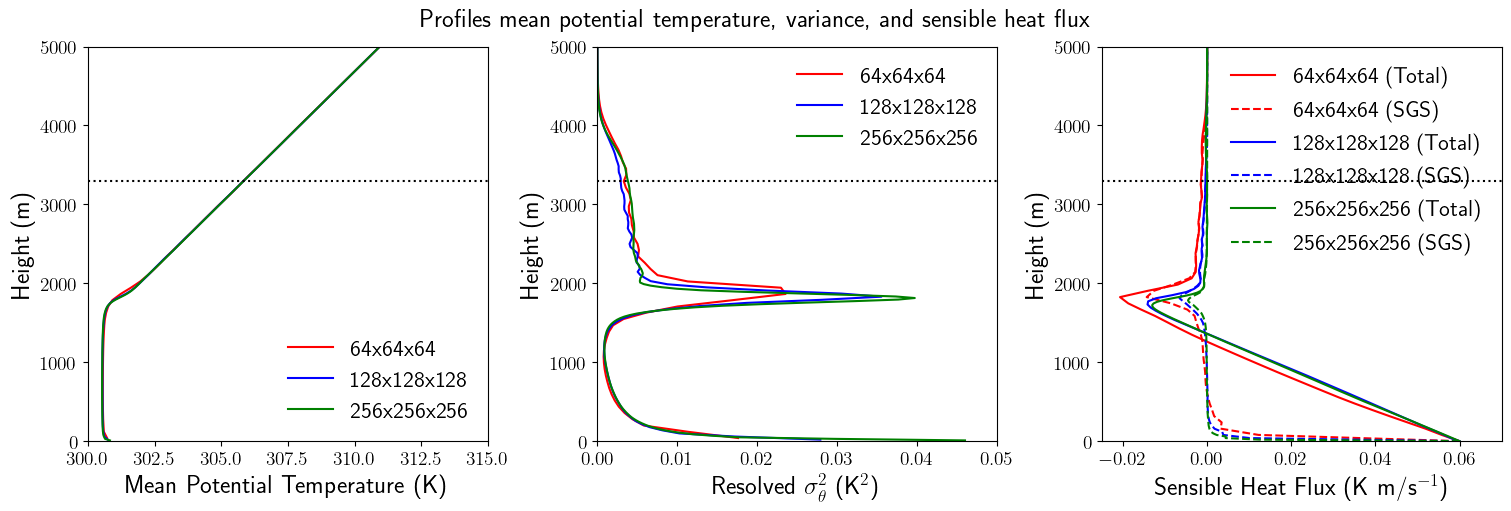

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

axs[0].plot(TH_avg_1, z_u_1, 'r-', label='64x64x64')
axs[0].plot(TH_avg_2, z_u_2, 'b-', label='128x128x128')
axs[0].plot(TH_avg_3, z_u_3, 'g-', label='256x256x256')
axs[0].axhline(y=3300, color='k', linestyle=':', linewidth=1.5)  
axs[0].set_xlabel(r"Mean Potential Temperature (K)")
axs[0].set_ylabel(r"Height (m)")
axs[0].set_xlim((300, 315))
axs[0].set_ylim((0, 5000))
axs[0].legend(frameon=False, loc='lower right')

axs[1].plot(TH2_avg_1, z_u_1, 'r-', label='64x64x64')
axs[1].plot(TH2_avg_2, z_u_2, 'b-', label='128x128x128')
axs[1].plot(TH2_avg_3, z_u_3, 'g-', label='256x256x256')
axs[1].axhline(y=3300, color='k', linestyle=':', linewidth=1.5)  
axs[1].set_xlabel(r"Resolved $\sigma_\theta^2$ (K$^2$)")
axs[1].set_ylabel(r"Height (m)")
axs[1].set_xlim((0, 0.05))
axs[1].set_ylim((0, 5000))
axs[1].legend(frameon=False, loc='upper right')

axs[2].plot(wTH_avg_1 + qz_avg_1, z_w_1, 'r-', label='64x64x64 (Total)')
axs[2].plot(qz_avg_1, z_w_1, 'r--', label='64x64x64 (SGS)')
axs[2].plot(wTH_avg_2 + qz_avg_2, z_w_2, 'b-', label='128x128x128 (Total)')
axs[2].plot(qz_avg_2, z_w_2, 'b--', label='128x128x128 (SGS)')
axs[2].plot(wTH_avg_3 + qz_avg_3, z_w_3, 'g-', label='256x256x256 (Total)')
axs[2].plot(qz_avg_3, z_w_3, 'g--', label='256x256x256 (SGS)')
axs[2].axhline(y=3300, color='k', linestyle=':', linewidth=1.5)  
axs[2].set_xlabel(r"Sensible Heat Flux (K m/s$^{-1}$)")
axs[2].set_ylabel(r"Height (m)")
axs[2].set_xlim((-0.025, 0.07))
axs[2].set_ylim((0, 5000))
axs[2].legend(frameon=False, loc='upper right')

fig.suptitle("Profiles mean potential temperature, variance, and sensible heat flux", fontsize=18)
plt.show()